In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

import os
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
# os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGL.so:/usr/lib/x86_64-linux-gnu/libGLEW.so'

import gym
import d4rl

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import patches

import equinox as eqx
import jax
import jax.numpy as jnp
import functools

from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence
from ott.solvers.linear import implicit_differentiation as imp_diff

import optax

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_psi(ensemble, s):
    return eqx.filter_vmap(ensemble.psi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_phi(ensemble, s):
    return eqx.filter_vmap(ensemble.phi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g, z), g - dim 29, z - dim 256
def eval_ensemble_icvf_latent_z(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g ,z ), g, z - dim 256
def eval_ensemble_icvf_latent_zz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_zz)(s, g, z)
    
@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_latent_zzz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_zzz)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=None, s=0, z=None))
def eqx_get_state_traj(ensemble, s, z):
    '''
    Function to compute pairwise distance between two trajectories
    '''
    s = jnp.tile(s, (z.shape[0], 1))
    return eval_ensemble_icvf_latent_zzz(icvf_model.value_learner.model, s, z, z)

@eqx.filter_jit
def get_gcvalue(agent, s, g, z):
    v_sgz_1, v_sgz_2 = eval_ensemble_icvf_viz(agent.value_learner.model, s, g, z)
    return (v_sgz_1 + v_sgz_2) / 2

def get_v_gz(agent, initial_state, target_goal, observations):
    initial_state = jnp.tile(initial_state, (observations.shape[0], 1))
    target_goal = jnp.tile(target_goal, (observations.shape[0], 1))
    return -1 * get_gcvalue(agent, initial_state, observations, target_goal)
    
def get_v_zz(agent, goal, observations):
    goal = jnp.tile(goal, (observations.shape[0], 1))
    return get_gcvalue(agent, observations, goal, goal)

@eqx.filter_vmap(in_axes=dict(agent=None, obs=None, goal=0))
def get_v_zz_heatmap(agent, obs, goal): # goal - traj
    goal = jnp.tile(goal, (obs.shape[0], 1))
    return get_gcvalue(agent, obs, goal, goal)

%matplotlib inline
%load_ext autoreload
%autoreload 2

pybullet build time: May 20 2022 19:45:31


In [2]:
jax.devices()

[gpu(id=0), gpu(id=1)]

In [3]:
from src.gc_dataset import GCSDataset
from utils.ds_builder import setup_datasets

env, expert_ds, agent_ds, agent_mean_states, agent_std_states = setup_datasets(expert_env_name="antmaze-large-diverse-v2",
                                          agent_env_name="antmaze-large-diverse-v2", expert_num=1,
                                          normalize_agent_states=False)

gcsds_params = GCSDataset.get_default_config()
gc_expert_dataset = GCSDataset(expert_ds, **gcsds_params)
gc_agent_dataset = GCSDataset(agent_ds, **gcsds_params)

expert_trajectory = gc_expert_dataset.get_expert_traj()['observations']

Target Goal:  (32.645816878500966, 24.97398858517164)
Target Goal:  (32.613867971884375, 24.22302720789735)


load datafile: 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]


  0%|          | 0/999000 [00:00<?, ?it/s]

Expert returns [1.116058125190916], mean 1.116058125190916


load datafile: 100%|██████████| 8/8 [00:01<00:00,  7.10it/s]


Number of terminal states: 2
Number of terminal states: 7183


In [4]:
%cd ..
from src.agents import icvf
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=expert_ds.dataset_dict['observations'][0],
                                     hidden_dims=[256, 256],
                                     pretrained_folder="antmaze-large-diverse",
                                     load_pretrained_icvf=True)

/home/nazar/projects/AILOT
Extra kwargs: {}


In [6]:
class OTRewardsExpert:

    def __init__(
        self, expert_traj,
    ):
        self.expert_states = expert_traj
        self.expert_z = eval_ensemble_psi(icvf_model.value_learner.model, expert_traj).mean(axis=0)
        self.sub_steps = 1

    def make_subs(self, z, sub_steps):
        sub_indx = jnp.minimum(jnp.arange(0, z.shape[0]) + sub_steps, z.shape[0] - 1)
        return jax.tree_map(lambda arr: arr[sub_indx], z)
    

    @eqx.filter_jit
    def get_z_and_start_index(self, obs):
        # obs - trajectory
        z = eval_ensemble_psi(icvf_model.value_learner.model, obs).mean(axis=0)
        diff = z[0][jnp.newaxis,] - self.expert_z #eqx_get_state_traj(icvf_model.value_learner.model, z[0][None], self.expert_z).mean(1)#z[0][jnp.newaxis,] - self.expert_z
        i_min =jnp.argmin((diff**2).sum(-1)).squeeze() #jnp.argmin(diff, -1).squeeze()
        return z, i_min, diff

    def compute_rewards(
        self,
        dataset
    ):
        rewards = []
        observations = dataset.dataset_dict['observations']
        episode_starts, episode_ends, episode_returns = gc_agent_dataset.dataset._trajectory_boundaries_and_returns()
        
        for i1 in tqdm(range(len(episode_starts))):
            zi, start_index, diff = self.get_z_and_start_index(observations[episode_starts[i1]:episode_ends[i1]])
            ri = self.compute_rewards_one_episode(zi, self.expert_z[start_index:])
            #print(eval_ensemble_icvf_latent_zzz(icvf_model.value_learner.model, zi[0][None], self.expert_z[start_index][5][None], self.expert_z[start_index][5][None]).mean(0))
            rewards.append(jax.device_get(ri))
                  
        return np.concatenate(rewards)


    @eqx.filter_jit
    def compute_rewards_one_episode(
        self, episode_obs, expert_obs
    ):

        za_1 = episode_obs
        za_2 = self.make_subs(za_1, self.sub_steps)
        x = jnp.concatenate([za_1, za_2], axis=1)

        ze_1 = expert_obs
        ze_2 = self.make_subs(ze_1, self.sub_steps)
        y = jnp.concatenate([ze_1, ze_2], axis=1)
        
        geom = pointcloud.PointCloud(x, y, epsilon=0.001)
        ot_prob = linear_problem.LinearProblem(geom)
        solver = sinkhorn.Sinkhorn(max_iterations=500, use_danskin=True)

        ot_sink = solver(ot_prob)
        transp_cost = jnp.sum(ot_sink.matrix * geom.cost_matrix, axis=1)
        rewards = -transp_cost * episode_obs.shape[0] / 10

        return rewards

    

In [7]:
expert = OTRewardsExpert(expert_trajectory)
rewards = expert.compute_rewards(gc_agent_dataset.dataset)

  0%|          | 0/7182 [00:00<?, ?it/s]

In [75]:
from src.dataset import Dataset

class ExpRewardsScaler:
    def init(self, rewards: np.ndarray):
        self.min = np.quantile(np.abs(rewards).reshape(-1), 0.0)
        self.max = np.quantile(np.abs(rewards).reshape(-1), 0.95)

    def scale(self, rewards: np.ndarray):
        # From paper
        return  5 * np.exp(rewards / self.max)


def get_subs(dataset: GCSDataset, add_steps: int):
    terminal_locs = dataset.terminal_locs
    indx = np.arange(dataset.dataset.dataset_dict['observations'].shape[0])
    final_state_indx = terminal_locs[np.searchsorted(terminal_locs, indx)] 
    way_indx = np.minimum(indx + add_steps, final_state_indx)
    subs = jax.tree_map(lambda arr: arr[way_indx], dataset.dataset.dataset_dict['observations'])
    return subs

sq_rewards = -jnp.sqrt(-rewards+0.001)
scaler = ExpRewardsScaler()
scaler.init(sq_rewards)
scaled_rewards = scaler.scale(sq_rewards).astype(np.float32)
print(jnp.quantile(scaled_rewards, 0.1), jnp.quantile(scaled_rewards, 0.5), jnp.quantile(scaled_rewards, 0.9))

1.9344496 2.3326588 3.7463155


In [10]:
from utils.ds_builder import load_trajectories

    
offline_traj = load_trajectories("antmaze-large-diverse-v2", scaled_rewards)
    
def compute_iql_reward_scale(trajs):
    """Rescale rewards based on max/min from the dataset.
    This is also used in the original IQL implementation.
    """
    trajs = trajs.copy()
    
    def compute_returns(tr):
        return sum([step[2] for step in tr])
    
    trajs.sort(key=compute_returns)
    reward_scale = 1000.0 / (
      compute_returns(trajs[-1]) - compute_returns(trajs[0]))
    return reward_scale

Target Goal:  (33.27187193345549, 24.24098681509032)


load datafile: 100%|██████████| 8/8 [00:01<00:00,  7.14it/s]


  0%|          | 0/999000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [94]:
ds = gc_agent_dataset.dataset.dataset_dict
episode_starts, episode_ends, episode_returns = gc_agent_dataset.dataset._trajectory_boundaries_and_returns()

q07 = jnp.quantile(scaled_rewards, 0.8)

data_with_ot_rewards = Dataset(
    {'observations': np.concatenate([ds['observations'][episode_starts[i]:episode_ends[i]] for i, j in enumerate(episode_starts)]).astype(np.float32)[scaled_rewards > q07],
    'next_observations': np.concatenate([ds['next_observations'][episode_starts[i]:episode_ends[i]] for i, j in enumerate(episode_starts)]).astype(np.float32)[scaled_rewards > q07],
    'actions': np.concatenate([ds['actions'][episode_starts[i]:episode_ends[i]] for i, j in enumerate(episode_starts)]).astype(np.float32)[scaled_rewards > q07],
    'rewards':scaled_rewards[scaled_rewards > q07] * 0.3 - 2,# try with -1, #[scaled_rewards > r_min],
    'masks': 1.0 - np.concatenate([ds['dones'][episode_starts[i]:episode_ends[i]] for i, j in enumerate(episode_starts)]).astype(np.float32)[scaled_rewards > q07],
    })#[scaled_rewards > r_min]})


In [95]:
from src.agents.iql_flax.common import Batch
from src.agents.iql_flax.learner import Learner
from src.agents.iql_flax.evaluation import evaluate

os.environ['CUDA_VISIBLE_DEVICES']="0,1"

print(jax.devices())

iql_agent_ot = Learner(
        5123,
        env.observation_space.sample()[np.newaxis],
        env.action_space.sample()[np.newaxis],#z_sample,
        max_steps=1000_000,
        expectile=0.9,
        discount=0.999,
        temperature=2)

pbar = tqdm(range(1000_000 + 1))
expert = OTRewardsExpert(expert_trajectory)

for i in pbar:
    sample = data_with_ot_rewards.sample(256)
    batch = Batch(
        observations=sample["observations"],
        next_observations=sample["next_observations"],
        actions = sample['actions'], #z / 10,
        rewards= sample["rewards"],
        masks= sample["masks"]
    )
    update_info = iql_agent_ot.update(batch)
    update_info['adv'] = None
    if i % 50_000 == 0 and i > 0:
        eval_stats, trajs = evaluate(iql_agent_ot, env, num_episodes=10)
        r_sum = 0
        for tr in trajs:
            z_tr, _, _ = expert.get_z_and_start_index(tr)
            r_tr = expert.compute_rewards_one_episode(z_tr, expert.expert_z)
            r_sqrt = -jnp.sqrt(-r_tr + 0.01)
            r_sum += r_sqrt.sum()
        print(r_sum, eval_stats)
        if eval_stats['return'] >= 0.8:
            break
        pbar.set_postfix(update_info)
    if i % 3000 == 0:
        pbar.set_postfix(update_info)

[gpu(id=0), gpu(id=1)]


  0%|          | 0/1000001 [00:00<?, ?it/s]

Target Goal:  (32.56787946879075, 24.782530272339784)
Target Goal:  (32.79411960903565, 24.783226461694536)
Target Goal:  (32.269169613374835, 24.24941773881946)
Target Goal:  (32.637001792484874, 25.279919790116413)
Target Goal:  (32.5566829460401, 24.803941581657487)
Target Goal:  (32.82784265339095, 25.05804135206265)
Target Goal:  (32.19998727187734, 24.815356179460082)
Target Goal:  (33.41364691192518, 24.591315015051105)
Target Goal:  (33.002256682388904, 25.27847910115836)
Target Goal:  (32.61230919235257, 24.288288963341095)
-2780.6482 {'return': 0.0, 'length': 1000.0}
Target Goal:  (32.21979390140766, 24.397845472348756)
Target Goal:  (33.34764754756742, 24.26914279058844)
Target Goal:  (32.51774328841916, 24.86026652744771)
Target Goal:  (33.40462871507464, 24.966610034910197)
Target Goal:  (33.179105733407226, 24.350671617482664)
Target Goal:  (32.33453863930101, 24.95582032211132)
Target Goal:  (33.03013062860489, 24.413853083916415)
Target Goal:  (32.9961248767331, 24.3632

KeyboardInterrupt: 

In [21]:
print(1)

1


Target Goal:  (33.19454816674776, 24.31812540579495)
Target Goal:  (31.845472, 24.854422)


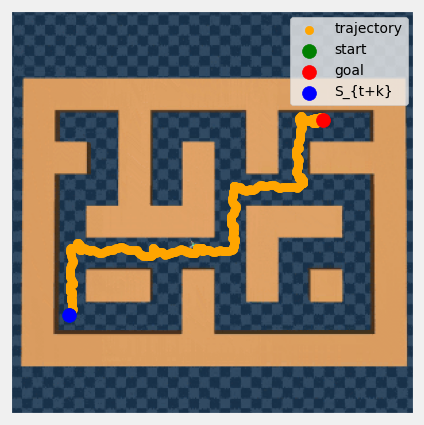

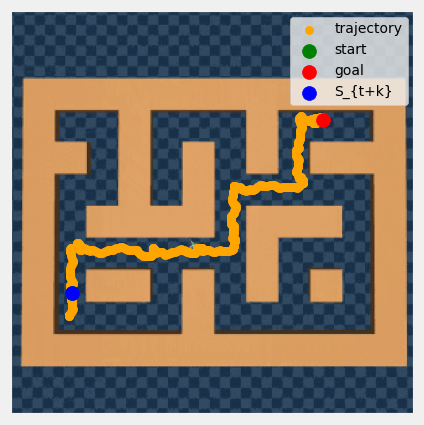

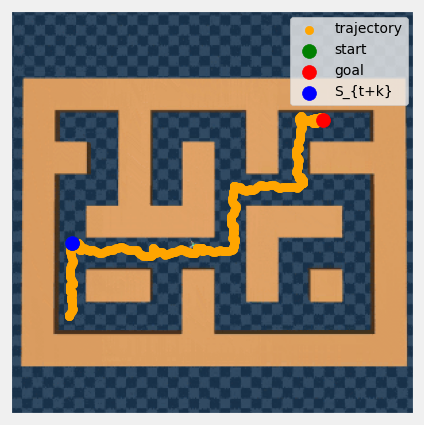

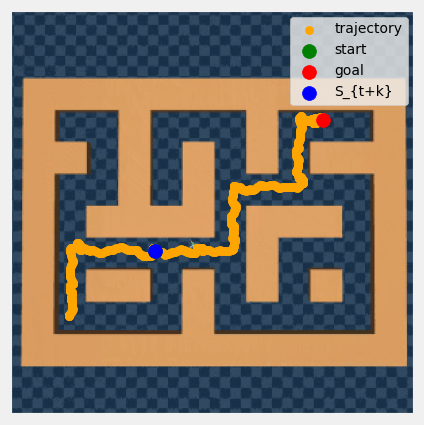

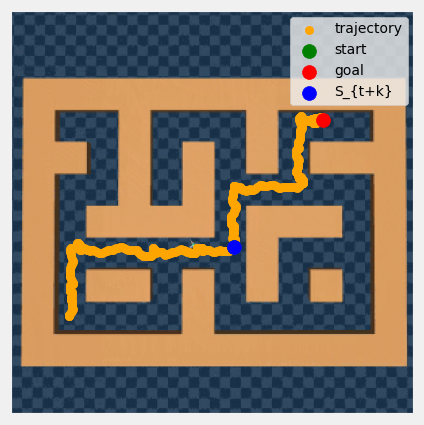

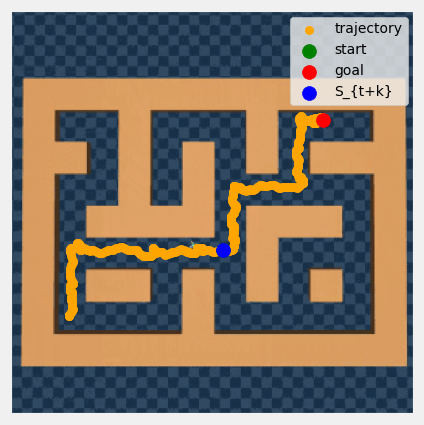

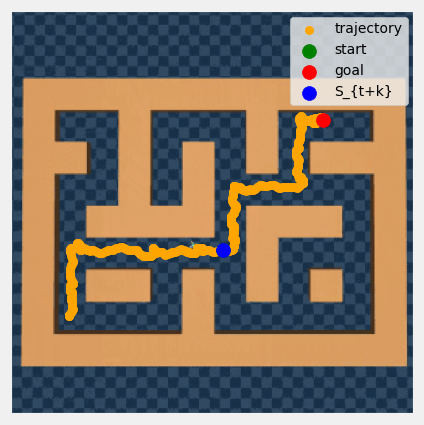

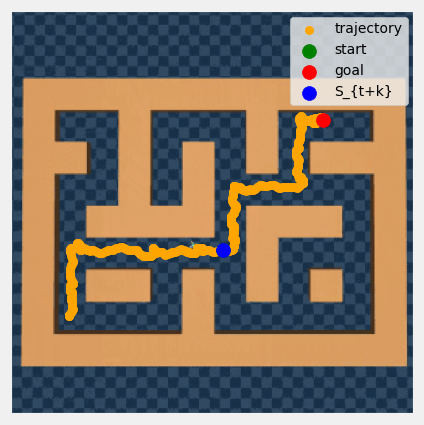

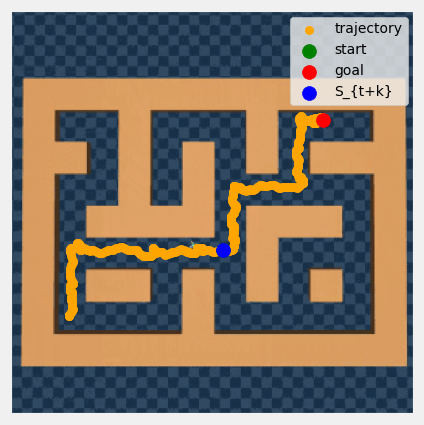

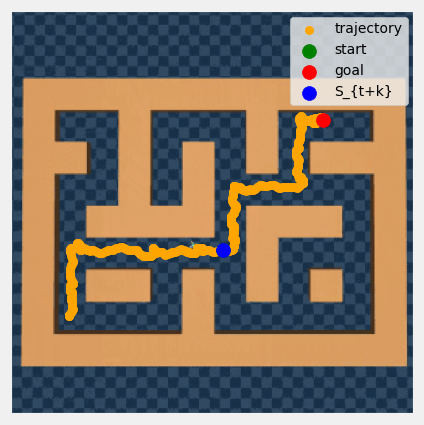

0.0


In [96]:
from gymnasium.utils import save_video

scales_shifts = [(6, 40), (-6, 230)]
def scale_and_shift(x, lst):
    return lst[0] * x + lst[1]
    
def plot_traj_image(traj, start, goal, subgoals, bgpath):
    fig, ax = plt.subplots(figsize=(5, 5))
    pimage = plt.imread(bgpath)
    ax.imshow(pimage)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(scale_and_shift(expert_trajectory[:, 0], scales_shifts[0]), scale_and_shift(expert_trajectory[:, 1], scales_shifts[1]), alpha=1, label='trajectory', color='orange')
    ax.scatter(scale_and_shift(start[0], scales_shifts[0]), scale_and_shift(start[1], scales_shifts[1]), c='g', s=100, label='start')
    ax.scatter(scale_and_shift(goal[0], scales_shifts[0]), scale_and_shift(goal[1], scales_shifts[1]), c='r', s=100, label='goal')
    ax.scatter(scale_and_shift(subgoals[0], scales_shifts[0]), scale_and_shift(subgoals[1], scales_shifts[1]), c='b', s=100, label='S_{t+k}')
    ax.legend(fontsize=10)

start_point = expert_trajectory[0]
target_goal = expert_trajectory[-1]
sample_key = jax.random.PRNGKey(42)

env.reset()
env.env.env.wrapped_env.set_xy((start_point[0], start_point[1]))
env.env.env.wrapped_env.set_target((target_goal[0], target_goal[1]))
start_point = env.env.env.wrapped_env._get_obs()
curr_point = start_point
frames=[]

i = 0
done = False
while not done:
    key, sample_key = jax.random.split(sample_key, 2)
    action = jax.device_get(iql_agent_ot.sample_actions(curr_point.squeeze(), temperature=0.0))
    new_obs, reward, done ,_ = env.step(action)
    
    os.environ['CUDA_VISIBLE_DEVICES']='1'
    frames.append(env.render(mode='rgb_array'))
    os.environ['CUDA_VISIBLE_DEVICES']='0,1'
    if done:
        print(reward)  
    if i % 100 == 0:
        plot_traj_image(sample, new_obs, target_goal, new_obs, "/home/nazar/projects/AILOT/antmaze-large.png")

    plt.show()
    curr_point = new_obs
    i+=1
# save_video.save_video(frames, video_folder='.', fps=env.env.env._wrapped_env.metadata['render_fps'])